# Project 2

You have been approached by The Director of Yemisi Shyllon Museum of Art (YSMA) to build a computer vision program with a graphical user interface (GUI) that would ask for a username and password from visitors to log in and view and perform image enhancements on the art collection at the museum. Given the knowledge of the collection categories from the previous project.

Hint: Use the Python Tinker library to build your GUI


In [70]:
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import re

In [71]:
def translate_image(image_path, dx, dy):
    img = cv2.imread(image_path, 0)
    rows, cols = img.shape
    
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    translated_img = cv2.warpAffine(img, M, (cols, rows))
    
    return img, translated_img
    
def reflect_image(image_path):
    img = cv2.imread(image_path, 0)
    rows, cols = img.shape
    
    M = np.float32([[1, 0, 0], [0, -1, rows]])
    reflected_img = cv2.warpAffine(img, M, (cols, rows))

    return img, reflected_img

def rotate_image(image_path, angle, scale):
    img = cv2.imread(image_path, 0)
    rows, cols = img.shape
    
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, scale)
    rotated_img = cv2.warpAffine(img, M, (cols, rows))

    return img, rotated_img

def crop_image(image_path, x1, y1, x2, y2):
    img = cv2.imread(image_path, 0)
    cropped_img = img[y1:y2, x1:x2]
    
    return img, cropped_img

def shear_image_x(image_path, shear_factor):
    img = cv2.imread(image_path, 0)
    rows, cols = img.shape
    
    M = np.float32([[1, shear_factor, 0], [0, 1, 0], [0, 0, 1]])
    sheared_img = cv2.warpPerspective(img, M, (int(cols*1.5), int(rows*1.5)))
    
    return img, sheared_img

def shear_image_y(image_path, shear_factor):
    img = cv2.imread(image_path, 0)
    rows, cols = img.shape
    
    M = np.float32([[1, 0, 0], [shear_factor, 1, 0], [0, 0, 1]])
    sheared_img = cv2.warpPerspective(img, M, (int(cols*1.5), int(rows*1.5)))
    
    return img, sheared_img

def apply_blur(image_path, blur_type):
    img = cv2.imread(image_path)
    
    if blur_type == 'Gaussian':
        blurred_img = cv2.GaussianBlur(img, (7, 7), 0)
    elif blur_type == 'Median':
        blurred_img = cv2.medianBlur(img, 5)
    elif blur_type == 'Bilateral':
        blurred_img = cv2.bilateralFilter(img, 9, 75, 75)
    else:
        print("Invalid blur type.")
        return
    return img, blurred_img



In [72]:
def format_title(title):
    title_without_format = title.split('.')[0]
    return ' '.join(word.capitalize() for word in title_without_format.split('-'))

def unformat_title(formatted_title):
    return '-'.join(word.lower() for word in formatted_title.split())

def get_numeric_input(prompt, error_message=None):
    while True:
        try:
            value = int(input(prompt))
            return value
        except ValueError:
            if error_message:
                print(error_message)
            else:
                print("Invalid input. Please enter a number.")


# Function to display categories
def display_categories():
    categories = ['Traditional Art', 'Modern Art', 'Contemporary Art']
    for i, category in enumerate(categories, 1):
        print(f"{i}. {category}")

def display_images(category):
    category = category.lower().replace(" ", "-")
    category_folder = f"../images/project-images/{category}/"
    images = sorted(os.listdir(category_folder))
    num_images = len(images)

    # Calculate the number of rows and columns for the grid
    num_cols = 4  # Adjust as needed
    num_rows = (num_images - 1) // num_cols + 1

    # Display images in a grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            img = cv2.imread(category_folder + images[i])
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax.set_title(f"{i + 1}. {format_title(images[i])}")
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()
    return category_folder, images


def select_image(category_folder, images):
    while True:
        choice = input("Enter the number of the image you want to transform (or 'exit' to quit): ")
        if choice.lower() == 'exit':
            return None
        if choice.isdigit():
            index = int(choice) - 1
            if 0 <= index < len(images):
                print(f"\nYou have selected image {index + 1}: {format_title(images[index])}")
                img = cv2.imread(category_folder + images[index])
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.title(f"{format_title(images[index])}")
                
                plt.show()
                return images[index]
        print("Invalid input. Please enter a valid image number.")

In [73]:
# Function to perform image transformations
def perform_transformation(image, transformation_choice):
    transformed_img = None
    transformation_names = [
        'Translate', 'Reflect', 'Rotate', 'Crop',
        'Shear X', 'Shear Y', 'Gaussian Blur',
        'Median Blur', 'Bilateral Blur'
    ]
    transformation_func = [
        translate_image, reflect_image, rotate_image, crop_image,
        shear_image_x, shear_image_y, apply_blur,
        apply_blur, apply_blur
    ]

    transformation_name = transformation_names[transformation_choice - 1]
    transformation_function = transformation_func[transformation_choice - 1]

    if transformation_choice in [1, 5, 6]:
        if transformation_choice in [1, 5, 6]:
            dx = int(dx_entry.get())
            dy = int(dy_entry.get()) if transformation_choice == 1 else 0
            transformed_img = transformation_function(image, dx, dy)
    elif transformation_choice == 4:
        x1 = int(x1_entry.get())
        y1 = int(y1_entry.get())
        x2 = int(x2_entry.get())
        y2 = int(y2_entry.get())
        transformed_img = transformation_function(image, x1, y1, x2, y2)
    elif transformation_choice in [7, 8, 9]:
        transformed_img = transformation_function(image, 'Gaussian' if transformation_choice == 7 else 'Median' if transformation_choice == 8 else 'Bilateral')
    else:
        angle = float(angle_entry.get())
        scale = float(scale_entry.get())
        transformed_img = transformation_function(image, angle, scale)
    
    if transformed_img is not None:
        show_images(image, transformed_img, transformation_name)
        

def show_images(original_img, transformed_img, transformation_name):
    # Plot the original and transformed images side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(cv2.cvtColor(transformed_img, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f"{transformation_name} Image")
    axes[1].axis('off')

    plt.show()

In [74]:
# Function to display options after successful login
def display_options():
    # Destroy the login window
    root.destroy()
    
    # Create the main application window
    main_window = tk.Tk()
    main_window.title("YSMA Art Collection Viewer")

    # Create and place widgets for viewing and enhancing images
    view_button = tk.Button(main_window, text="View Art Collection", command=display_images)
    view_button.pack(pady=10)

    enhance_button = tk.Button(main_window, text="Enhance Images", command=perform_transformation())
    enhance_button.pack(pady=10)

    # Start the Tkinter event loop for the main window
    main_window.mainloop()

In [75]:
def open_transformation_window():
    # Create a new window for image transformation
    transformation_window = tk.Toplevel()
    transformation_window.title("Image Transformation")
    transformation_window.geometry("800x600")

    # Function to perform image transformation
    def perform_transformation():
        # Get transformation choice
        transformation = transformation_choice.current() + 1
        
        # Perform selected transformation
        if transformation == 1:
            dx = int(dx_entry.get())
            dy = int(dy_entry.get())
            img, transformed_img = translate_image(image_path, dx, dy)
        elif transformation == 2:
            img, transformed_img = reflect_image(image_path)
        # Add other transformation options here

        # Display original and transformed images
        if transformed_img is not None:
            # Plot the original image
            plt.subplot(1, 2, 1)
            plt.title("Original Image")
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

            # Plot the transformed image
            plt.subplot(1, 2, 2)
            plt.title(f"Transformed Image")
            plt.imshow(cv2.cvtColor(transformed_img, cv2.COLOR_BGR2RGB))
            plt.show()

    # Add widgets for image transformation
    transformation_frame = ttk.Frame(transformation_window)
    transformation_frame.pack(expand=True, padx=20, pady=20)

    # Transformation Choice
    transformation_choice_label = ttk.Label(transformation_frame, text="Select Transformation:")
    transformation_choice_label.grid(row=0, column=0, sticky=tk.W, pady=5)

    transformations = ['Translate', 'Reflect']  # Add other transformations
    transformation_choice = ttk.Combobox(transformation_frame, values=transformations, state='readonly')
    transformation_choice.grid(row=0, column=1, sticky=tk.W, pady=5)
    transformation_choice.current(0)

    # Entry fields for transformation parameters
    dx_label = ttk.Label(transformation_frame, text="dx:")
    dx_label.grid(row=1, column=0, sticky=tk.W, pady=5)
    dx_entry = ttk.Entry(transformation_frame)
    dx_entry.grid(row=1, column=1, sticky=tk.W, pady=5)

    dy_label = ttk.Label(transformation_frame, text="dy:")
    dy_label.grid(row=2, column=0, sticky=tk.W, pady=5)
    dy_entry = ttk.Entry(transformation_frame)
    dy_entry.grid(row=2, column=1, sticky=tk.W, pady=5)

    # Button to perform transformation
    transform_button = ttk.Button(transformation_frame, text="Transform Image", command=perform_transformation)
    transform_button.grid(row=3, column=0, columnspan=2, pady=(20, 0))


In [76]:
def open_file():
    filepath = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg;*.png;*.jpeg")])
    if filepath:
        # Read the image
        image = cv2.imread(filepath)
        # Convert BGR to RGB for display with Matplotlib
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Display the image
        plt.imshow(image)
        plt.axis("off")
        plt.show()

def perform_transformation():
    selected_transformation = transformation_choice.get()
    if selected_transformation == "Select Transformation":
        messagebox.showerror("Error", "Please select a transformation.")
        return

    if selected_transformation == "Translate":
        dx = int(dx_entry.get())
        dy = int(dy_entry.get())
        # Perform translation
        # img = cv2.imread(image_path)
        # transformed_img = translate_image(img, dx, dy)
        # Display transformed image
        # plt.imshow(transformed_img)
        pass
    elif selected_transformation == "Reflect":
        # Perform reflection
        pass
    elif selected_transformation == "Rotate":
        # Perform rotation
        pass
    # Add similar logic for other transformations

    # Display the transformed image
    # plt.show()
    messagebox.showinfo("Transformation Completed", "Transformation applied successfully.")

def open_transformation_window():
    # Create a new window for image transformation
    transformation_window = tk.Toplevel()
    transformation_window.title("Image Transformation")

    # Frame for transformation options
    transformation_frame = ttk.Frame(transformation_window, padding="10")
    transformation_frame.pack(fill="both", expand=True)

    # Select Image Button
    select_image_button = ttk.Button(transformation_frame, text="Select Image", command=open_file)
    select_image_button.grid(row=0, column=0, padx=5, pady=5, sticky="ew")

    # Transformation Dropdown
    transformations = ["Select Transformation", "Translate", "Reflect", "Rotate", "Crop", "Shear X", "Shear Y", "Gaussian Blur", "Median Blur", "Bilateral Blur"]
    transformation_choice = ttk.Combobox(transformation_frame, values=transformations, state="readonly")
    transformation_choice.current(0)
    transformation_choice.grid(row=1, column=0, padx=5, pady=5, sticky="ew")

    # Parameters for transformation
    dx_label = ttk.Label(transformation_frame, text="dx:")
    dx_label.grid(row=2, column=0, padx=5, pady=5, sticky="w")
    dx_entry = ttk.Entry(transformation_frame)
    dx_entry.grid(row=2, column=1, padx=5, pady=5, sticky="ew")
    dy_label = ttk.Label(transformation_frame, text="dy:")
    dy_label.grid(row=3, column=0, padx=5, pady=5, sticky="w")
    dy_entry = ttk.Entry(transformation_frame)
    dy_entry.grid(row=3, column=1, padx=5, pady=5, sticky="ew")

    # Button to perform transformation
    transform_button = ttk.Button(transformation_frame, text="Transform Image", command=perform_transformation)
    transform_button.grid(row=4, column=0, columnspan=2, padx=5, pady=5, sticky="ew")

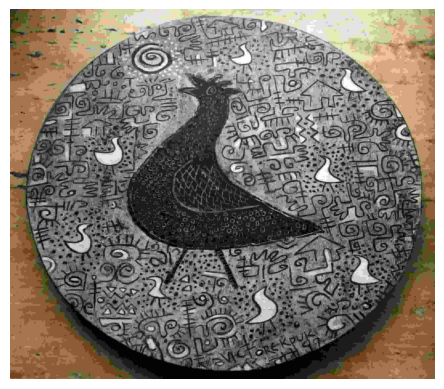

In [77]:
import tkinter as tk
from tkinter import ttk, messagebox

def login():
    username = username_entry.get()
    password = password_entry.get()

    if username == "admin" and password == "password":
        messagebox.showinfo("Login Successful", "Welcome, Admin!")
        root.destroy()  
        open_transformation_window()  
    else:
        messagebox.showerror("Login Failed", "Invalid username or password.")

# Create main application window
root = tk.Tk()
root.title("YSMA Image Transformation App - Login")
root.geometry("400x200")

# Get screen width and height
screen_width = root.winfo_screenwidth()
screen_height = root.winfo_screenheight()

# Calculate x and y coordinates for the Tk root window to be centered
x = (screen_width / 2) - (400 / 2)
y = (screen_height / 2) - (200 / 2)

# Set the dimensions and position of the window
root.geometry(f"400x200+{int(x)}+{int(y)}")
root.resizable(False, False)

# Apply a modern style
style = ttk.Style()
style.theme_use("vista")  # Choose a theme
style.configure("TLabel", padding=6)
style.configure("TEntry", padding=6)
style.configure("TButton", padding=6)

# Login Frame
login_frame = ttk.Frame(root)
login_frame.pack(expand=True, padx=20, pady=20)

# Username Label and Entry
username_label = ttk.Label(login_frame, text="Username:")
username_label.grid(row=0, column=0, sticky=tk.W)

username_entry = ttk.Entry(login_frame, width=30)
username_entry.grid(row=0, column=1, sticky=tk.W, pady=5)

# Password Label and Entry
password_label = ttk.Label(login_frame, text="Password:")
password_label.grid(row=1, column=0, sticky=tk.W)

password_entry = ttk.Entry(login_frame, show="*", width=30)
password_entry.grid(row=1, column=1, sticky=tk.W, pady=5)

# Login Button
login_button = ttk.Button(login_frame, text="Login", command=login, width=30)
login_button.grid(row=2, column=0, columnspan=2, pady=(20, 0))

# Start the Tkinter event loop
root.mainloop()
